# Feature Identification and Calculation

In [223]:
from sdanalysis.order import compute_neighbours, relative_orientations, relative_distances
from sdanalysis import HoomdFrame
import gsd.hoomd

import sys
sys.path.append("../src")

import trimer

In [37]:
fname = "../data/simulation/trimer/dump-Trimer-P1.00-T0.30-p2.gsd"
with gsd.hoomd.open(fname) as trj:
    snap = HoomdFrame(trj[0])

## Manual Classification

Which molecules are crystalline and which are liquid

In [225]:
classes = trimer.classify_mols(snap, 'p2')

## Nearest Neighbours

In [226]:
neighs = compute_neighbours(snap.box, snap.position)

## Relative Orientation

- Angles where there is no neighbour are 0
- Ordered by distance to neighbour

In [227]:
orient = relative_orientations(snap.box, snap.position, snap.orientation)

In [193]:
mask = classes < 4
X = orient[mask]
y = classes[mask]

### Visualisation

In [194]:
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt

In [195]:
pca = PCA(n_components=2)
X_r = pca.fit_transform(X)

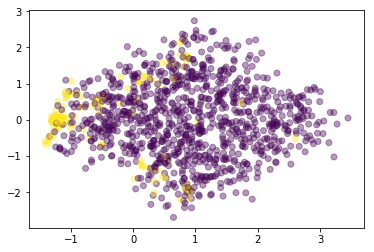

In [196]:
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.4, c=y);

In [197]:
kpca = KernelPCA(n_components=2, kernel='rbf')
X_r = kpca.fit_transform(X)

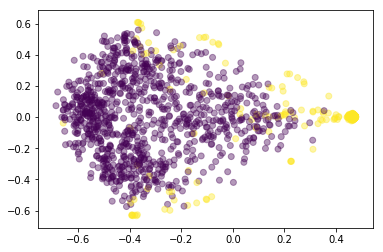

In [198]:
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.4, c=y);

## Orientation and Distance

In [210]:
orientation = relative_orientations(snap.box, snap.position, snap.orientation)
distance = relative_distances(snap.box, snap.position)
distance[np.isnan(distance)] = 0
combined = np.concatenate((orientation, distance), axis=1)

/home/malcolm/.miniconda/envs/MLCrystals/lib/python3.6/site-packages/sdanalysis/order.py:151: FreudDeprecationWarning: The getRsqList function is deprecated in favor of the r_sq_list class attribute and will be removed in a future version of freud.
  return np.sqrt(neighbours.getRsqList())
/home/malcolm/.miniconda/envs/MLCrystals/lib/python3.6/site-packages/sdanalysis/order.py:151: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(neighbours.getRsqList())


In [211]:
mask = classes < 4
X = combined[mask]
y = classes[mask]

In [212]:
pca = PCA(n_components=2, whiten=True)
X_r = pca.fit_transform(X)

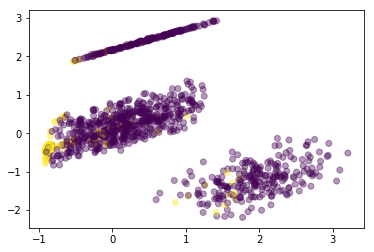

In [213]:
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.4, c=y);

In [220]:
kpca = KernelPCA(n_components=2, kernel='rbf')
X_r = kpca.fit_transform(X)

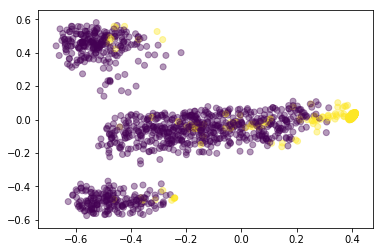

In [221]:
plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.4, c=y);